<a href="https://colab.research.google.com/github/ayushmangupta/TF2/blob/master/MobileNetV2_BoardDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
%matplotlib inline

import cv2
from joblib import Parallel, delayed
import multiprocessing
import random
from tqdm import tqdm_notebook
import numpy as np
#from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import skimage
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk

import tensorflow as tf
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import h5py
from tensorflow.keras.models import load_model
print(tf.__version__)
print(tf.test.is_gpu_available())




In [0]:


from google.colab import files
uploaded = files.upload()

Saving disk0.jpeg to disk0.jpeg
Saving disk1.jpeg to disk1.jpeg
Saving disk2.jpg to disk2.jpg


In [0]:
batch =2000
white = cv2.imread("disk0.jpeg")
black = cv2.imread("disk1.jpeg")
blank = cv2.imread("disk2.jpg")
from skimage.transform import resize
w_r= resize(white, (100, 100), anti_aliasing=True)
b_r= resize(black, (100, 100), anti_aliasing=True)
blank_r= resize(blank, (100, 100), anti_aliasing=True)
from tensorflow.keras.models import load_model
disks = [w_r,b_r,blank_r]
disks_array = [0,1,2]

def aug(img):
    bblur =iaa.GaussianBlur(sigma=(0,np.random.randint(2)))
    img= bblur.augment_image(img)
    noise = iaa.AdditiveGaussianNoise(loc=0.0,scale=np.random.choice([.01,.02,.03,.04,0.05,0.06,0.07,0.08,0.09]))
    img = noise.augment_image(img.astype(np.float32))
    pad = iaa.Pad(keep_size=True,px=(np.random.randint(4,15),np.random.randint(4,15),np.random.randint(4,15),np.random.randint(4,15)))
    img =  pad.augment_image(img)
    image_rotate = iaa.Affine(rotate=(np.random.randint(-12,12),np.random.randint(-10,10)))
    image_ = image_rotate.augment_image(img)
    img = img.astype(np.float64)
    return image_
#plot(aug(img))

def create_board():
    #np.random.seed(seed=1)
    #starter = np.vstack([disks[np.random.choice([0,1,2])] for x in range(8)])
    starter_array = np.vstack([disks_array[np.random.choice([0,1,2])] for x in range(8)])
    #main_b = np.array([])
    for i in range(7):
        #starter = np.hstack([starter,np.vstack([disks[np.random.choice([0,1,2])] for x in range(8)])])
        starter_array = np.hstack([starter_array,np.vstack([disks_array[np.random.choice([0,1,2])] for x in range(8)])])
        
    #print(starter_array)
    return starter_array
  
  
def create_board_image(arr):
    x = np.vstack([np.hstack([disks[j] for j in i]) for i in arr] )
    return resize(x, (224,224), anti_aliasing=True)
  
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

data_img = []
data_y = []
for d in tqdm_notebook(range(batch)):
    arr =  create_board()
    img = create_board_image(arr)
    y = arr.flatten()
    y = one_hot(y,3).flatten()
    
    data_img.append(img)
    data_y.append(y)
    
data_img = np.reshape(data_img,[batch,224,224,3])
data_img = np.array(data_img)
for ix in range(len(data_img)):
    data_img[ix] = aug(data_img[ix]) 

data_y = np.array(data_y)

In [0]:
!ls

disk0.jpeg  disk1.jpeg	disk2.jpg  sample_data


In [0]:
#loded_model = load_model("")

In [0]:

model = tfk.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 3s 0us/step


In [0]:

y = model.output
print(y.shape)
y = tfkl.Flatten()(y)
y = tfkl.Dense(192, activation='sigmoid', name='class_id')(y)

(None, 7, 7, 1280)


In [0]:
#print(data_img.shape,data_y.shape)

In [0]:
# for ix in range(1):
#   plot(np.squeeze(data_img[ix+6],2))
#   print(data_y[ix+6])

In [0]:
opt = tf.keras.optimizers.RMSprop(lr = 0.0001)

In [0]:
new_model = tfk.Model(inputs=model.input, outputs=y)

In [0]:
new_model.compile(loss='binary_crossentropy',
            optimizer=opt,
              metrics=['accuracy'])

In [0]:
#new_model.summary()

In [0]:
new_model.load_weights("boardmodelResnet3JulyMovV2.h5")

ValueError: ignored

In [0]:
!ls

disk0.jpeg  disk1.jpeg	disk2.jpg  sample_data


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/boardmodelResnet3july.h5" 
#model = load_model(path)

# filepath="weights-board-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
new_model.fit(x=data_img, y=data_y, validation_split=0.1, epochs=10, batch_size=10, verbose=2)

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1800/1800 - 46s - loss: 3.2092e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 2/10
1800/1800 - 38s - loss: 4.8263e-05 - accuracy: 1.0000 - val_loss: 2.8262e-04 - val_accuracy: 0.9998
Epoch 3/10
1800/1800 - 38s - loss: 2.3879e-05 - accuracy: 1.0000 - val_loss: 5.2996e-05 - val_accuracy: 1.0000
Epoch 4/10
1800/1800 - 38s - loss: 3.2442e-06 - accuracy: 1.0000 - val_loss: 2.1618e-05 - val_accuracy: 1.0000
Epoch 5/10
1800/1800 - 39s - loss: 1.3474e-06 - accuracy: 1.0000 - val_loss: 1.1467e-05 - val_accuracy: 1.0000
Epoch 6/10
1800/1800 - 39s - loss: 1.6905e-06 - accuracy: 1.0000 - val_loss: 6.8406e-06 - val_accuracy: 1.0000
Epoch 7/10
1800/1800 - 38s - loss: 5.0199e-07 - accuracy: 1.0000 - val_loss: 6.7760e-06 - val_accuracy: 1.0000
Epoch 8/10
1800/1800 - 39s - loss: 5.1933e-07 - accuracy: 1.0000 - val_loss: 7.3264e-06 - val_accuracy: 1.0000
Epoch 9/10
1800/1800 - 39s - loss: 2.9444e-07 - accuracy: 1.0000 - va

In [0]:
new_model.save("board3JulyMovV2.h5")

In [0]:
files.download("board3JulyMovV2.h5")

KeyboardInterrupt: ignored

In [0]:
new_model.evaluate(x=data_img,y=data_y)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive

In [0]:
root_path = 'gdrive/My Drive/pygameModel/board3JulyMovV2.h5'

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()

In [0]:
new_model.save(root_path)

In [0]:
import matplotlib.pyplot as plt

In [0]:
model.predict()

In [0]:
new_model.save_weights(root_path)

W0703 14:15:46.637022 139800211355520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


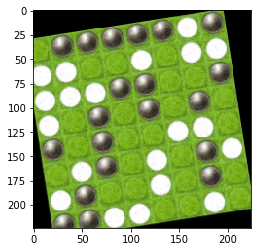

In [0]:
plt.imshow(data_img[0])

W0703 14:21:34.480076 139800211355520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


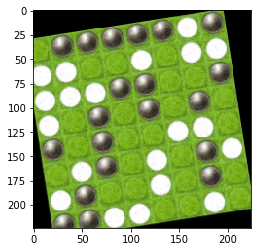

In [0]:
prediction = new_model.predict(data_img)
pred = prediction[0]
plt.imshow(data_img[0])


In [0]:
a = prediction[0]

a = a.reshape([64,3])
a = np.round(a)
print(a)
b=np.array([np.where(r==1)[0][0] for r in a])
print(b)
b = b.reshape([8,8])
plt.imshow(create_board_image(b))

In [0]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________